In [1]:
## Imports

import cv2
from sklearn.cluster import KMeans
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from skimage.segmentation import slic

plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]



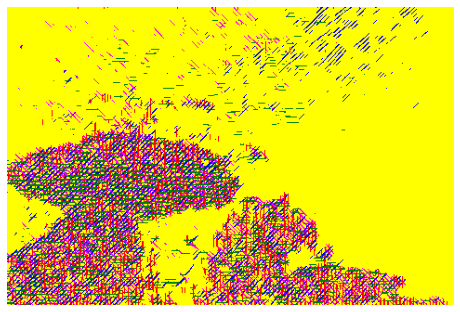

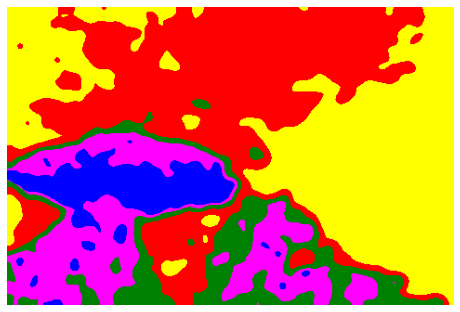

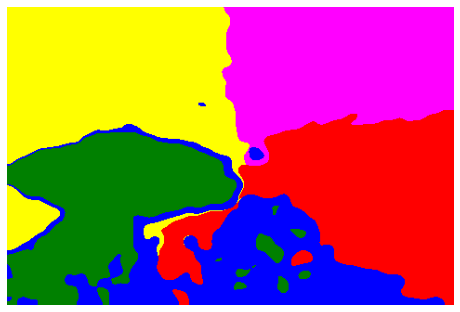

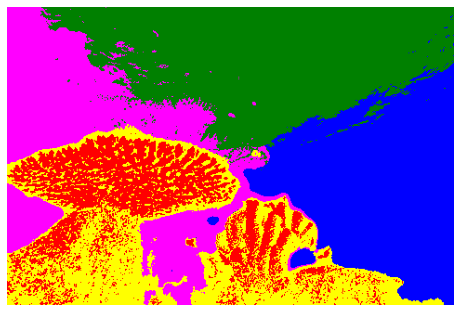

In [3]:
## Gaborfilters
image = cv2.imread("101027.jpg")[:,:,::-1]
def applyfilter(A, g, disable_blur = False, disable_spatial = False, disable_norm = False, disable_color = False, save_bank_results = False, mr = False):
    if A.shape[2]==3:
        Agray = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY)
    elif A.shape[2] == 1:
        Agray = A
        
    numRows = Agray.shape[0]
    numCols = Agray.shape[1]
    sizeFactors = np.array([0.25])
    sizeFactors = np.power(2, sizeFactors)
    gabormag = np.ndarray((Agray.shape[0], Agray.shape[1], g.shape[2]*len(sizeFactors)))
    sigmas = np.ndarray((g.shape[2]+1)*len(sizeFactors))
    
#    for i in range(g.shape[2]):
#        plt.subplot(15, 15, i+1)
#        plt.imshow(g[:,:,i], cmap="gray")
#        plt.imshow(cv2.resize(g[:,:,i], (g[:,:,i].shape[0]*sizeFactors[-1], g[:,:,i].shape[1]*sizeFactors[-1]), interpolation = cv2.INTER_LANCZOS4))
#    plt.show()
    
    for i in range(g.shape[2]):
        for s in range(len(sizeFactors)):
            gabormag[:, :, i*len(sizeFactors)+s] = cv2.filter2D(Agray, -1, cv2.resize(g[:,:,i], (int(g[:,:,i].shape[0]*sizeFactors[s]), int(g[:,:,i].shape[1]*sizeFactors[s])), interpolation = cv2.INTER_LANCZOS4), borderType=cv2.BORDER_REPLICATE)
            sigmas[i*len(sizeFactors)+s] = np.sqrt(2)*g.shape[0]*sizeFactors[s]/49

    if save_bank_results == True:
        for i in range(gabormag.shape[2]):
         #   plt.subplot(1, 1, i+1)
            plt.imshow(gabormag[:, :, i])
            plt.axis('off')
            plt.savefig("GEN_tsugf_filterbank_101027_"+str(i+1)+".png", bbox_inches="tight", pad_inches = 0)
         #   plt.show()     
    if disable_blur == False:    
        for i in range(gabormag.shape[2]):
            gabormag[:, :, i] = cv2.GaussianBlur(gabormag[:, :, i], (0, 0), 3*sigmas[i])

    X = np.arange(1, numCols + 1)
    Y = np.arange(1, numRows + 1)
    X, Y = np.meshgrid(X, Y)
        
    numPoints = numRows * numCols
    featureSet = gabormag
    
    if mr is True:
        argsort = np.argsort(featureSet[:,:,:-2].sum(axis=(0,1)))
        maxresp = featureSet[:, :, argsort]
        maxresp = maxresp[:,:,:(6*len(sizeFactors))]
        rotinv = featureSet[:, :, -2:]
        featureSet = np.concatenate((maxresp, rotinv), 2)
    
    if disable_spatial == False:
        featureSet = np.concatenate((featureSet, np.expand_dims(X, axis=2)), 2)
        featureSet = np.concatenate((featureSet, np.expand_dims(Y, axis=2)), 2)
    
    if A.shape[2]==3 and disable_color == False:
        featureSet = np.concatenate((featureSet, np.expand_dims(A[:,:,0], axis=2)), 2)
        featureSet = np.concatenate((featureSet, np.expand_dims(A[:,:,1], axis=2)), 2)
        featureSet = np.concatenate((featureSet, np.expand_dims(A[:,:,2], axis=2)), 2)

    X = featureSet.reshape(numPoints, -1)

    #for i in range(X.shape[1]):
    #    plt.subplot(20, 4, i+1)
    #    plt.imshow(X[:, i].reshape((A.shape[0],A.shape[1])))
    #plt.show()
    
    
    if disable_norm == False:
        X = X - X.mean(axis=0)
        X = X / X.std(axis=0, ddof=1)
    X = X[:, ~np.isnan(X).any(axis=0)]
    X = X[:, ~np.isinf(X).any(axis=0)]
    
    
    X = X.reshape(A.shape[0], A.shape[1], -1)
    
    
    if disable_spatial == False:
          X[:,:,-2:]=  X[:,:,-2:]*1

    if disable_color == False:
      if A.shape[2]==3:
        X[:,:,-5:-3]=  X[:,:,-5:-3]*1
      elif A.shape[2]==1:
        X[:,:,-3]=  X[:,:,-3]*1
    X = X.reshape(numPoints, -1)

    L = KMeans(n_clusters=5, n_init=20, max_iter=1000, n_jobs=10).fit(X).labels_
    
    return L

mat = sio.loadmat("../../code/filterbanks/filterbanks.mat")
g = mat["TSUGFfilters"]

#tags = Parallel(n_jobs=5, backend="threading", verbose=10)(delayed(applyfilter)(A, g) for A in images)
#tags = applyfilter(image, g)

plt.imshow(label2rgb(applyfilter(image, g, disable_blur = True, disable_spatial = True, disable_norm = True, disable_color = True, mr = False).reshape((image.shape[0],image.shape[1]))))
plt.axis('off')
plt.savefig("GEN_tsugf_filterbank_101027_raw"+".png", bbox_inches="tight", pad_inches = 0)
plt.show()

plt.imshow(label2rgb(applyfilter(image, g, disable_spatial = True, disable_norm = True, disable_color = True, mr = False).reshape((image.shape[0],image.shape[1]))))
plt.axis('off')
plt.savefig("GEN_tsugf_filterbank_101027_blur"+".png", bbox_inches="tight", pad_inches = 0)
plt.show()

#plt.imshow(label2rgb(applyfilter(image, g, disable_color = True, disable_spatial = True).reshape((image.shape[0],image.shape[1]))))
#plt.axis('off')
#plt.savefig("GEN_tsugf_filterbank_101027_blur_norm"+".png", bbox_inches="tight", pad_inches = 0)
#plt.show()

plt.imshow(label2rgb(applyfilter(image, g, disable_color = True, mr = False).reshape((image.shape[0],image.shape[1]))))
plt.axis('off')
plt.savefig("GEN_tsugf_filterbank_101027_blur_norm_spatial"+".png", bbox_inches="tight", pad_inches = 0)
plt.show()

plt.imshow(label2rgb(applyfilter(image, g, save_bank_results = True, mr = False).reshape((image.shape[0],image.shape[1]))))
plt.axis('off')
plt.savefig("GEN_tsugf_filterbank_101027_blur_norm_spatial_color"+".png", bbox_inches="tight", pad_inches = 0)
plt.show()
